In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import HeatMap
import os
import webbrowser
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from calendar import monthrange
import joblib
from scipy import stats
import plotly.express as px
from sklearn.cluster import KMeans
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from prophet import Prophet


/Users/turan/Downloads/HideNSeek-main 2/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/Crime_data.csv')
print(f"Shape of the dataset: {df.shape}")
print(f"Columns in the dataset: {df.columns.tolist()}")


Shape of the dataset: (918443, 28)
Columns in the dataset: ['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON']


In [3]:
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'], format='%m/%d/%Y %I:%M:%S %p')
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')

# Removing vict age less than 0 and greater than 100
df = df[(df['Vict Age'] > 0) & (df['Vict Age'] <= 100)]  

df['DayOfWeek'] = df['DATE OCC'].dt.day_name()
df['Hour'] = df['DATE OCC'].dt.hour
df['Year'] = df['DATE OCC'].dt.year
df['Month'] = df['DATE OCC'].dt.month


In [4]:
# We are dropping critical columns with missing values
critical_columns = ['Crm Cd Desc', 'AREA NAME', 'Vict Sex', 'Vict Descent']
df.dropna(subset=critical_columns, inplace=True)



In [5]:
categorical_cols = ['Crm Cd Desc', 'AREA NAME', 'Weapon Desc', 'Premis Desc', 'Status Desc', 'Vict Sex', 'Vict Descent']

# Apply uppercasing and stripping to each column in the list
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.str.upper().str.strip())

In [6]:
# Impute missing values in non-critical columns
non_critical_cols_with_defaults = {
    'Weapon Used Cd': 'No Weapon',
    'Crm Cd 1': df['Crm Cd 1'].mode()[0],
    'Premis Cd': df['Premis Cd'].mode()[0],
    'LOCATION': 'Unknown',
    'Cross Street': 'Unknown'
}
df.fillna(non_critical_cols_with_defaults, inplace=True)

In [7]:
#Find null values
print(f"Number of missing values in each column: {df.isnull().sum()}")

Number of missing values in each column: DR_NO                  0
Date Rptd              0
DATE OCC               0
TIME OCC               0
AREA                   0
AREA NAME              0
Rpt Dist No            0
Part 1-2               0
Crm Cd                 0
Crm Cd Desc            0
Mocodes             5297
Vict Age               0
Vict Sex               0
Vict Descent           0
Premis Cd              0
Premis Desc          217
Weapon Used Cd         0
Weapon Desc       394375
Status                 0
Status Desc            0
Crm Cd 1               0
Crm Cd 2          633762
Crm Cd 3          684236
Crm Cd 4          686280
LOCATION               0
Cross Street           0
LAT                    0
LON                    0
DayOfWeek              0
Hour                   0
Year                   0
Month                  0
dtype: int64


In [8]:
# Dropping Mocodes and Hour columns
df.drop('Mocodes', axis=1, inplace=True)
df.drop('Hour', axis=1, inplace=True)

#Filling missing values
df['Premis Desc'] = df['Premis Desc'].fillna('UNKNOWN')
df['Weapon Desc'] = df['Weapon Desc'].fillna('NaN')


# Dropping additional crime code columns
df.drop(['Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4'], axis=1, inplace=True)


print(df.isnull().sum())

DR_NO             0
Date Rptd         0
DATE OCC          0
TIME OCC          0
AREA              0
AREA NAME         0
Rpt Dist No       0
Part 1-2          0
Crm Cd            0
Crm Cd Desc       0
Vict Age          0
Vict Sex          0
Vict Descent      0
Premis Cd         0
Premis Desc       0
Weapon Used Cd    0
Weapon Desc       0
Status            0
Status Desc       0
Crm Cd 1          0
LOCATION          0
Cross Street      0
LAT               0
LON               0
DayOfWeek         0
Year              0
Month             0
dtype: int64


In [9]:

# We are cutting off the data to only include data after the initial stability cut-off date and before the final cut-off date to have a stable dataset
initial_stability_cutoff_date = pd.to_datetime('2020-02-01') 
final_cutoff_date = pd.to_datetime('2024-02-01')

df = df[(df['DATE OCC'] >= initial_stability_cutoff_date) & (df['DATE OCC'] < final_cutoff_date)]


In [10]:
# Aggregating the data to get the number of crimes per day
crime_counts_per_day = df.groupby(df['DATE OCC'].dt.date)['Crm Cd'].count().reset_index()
crime_counts_per_day.columns = ['Date', 'CrimeCount']

df = df.merge(crime_counts_per_day, left_on=df['DATE OCC'].dt.date, right_on='Date')

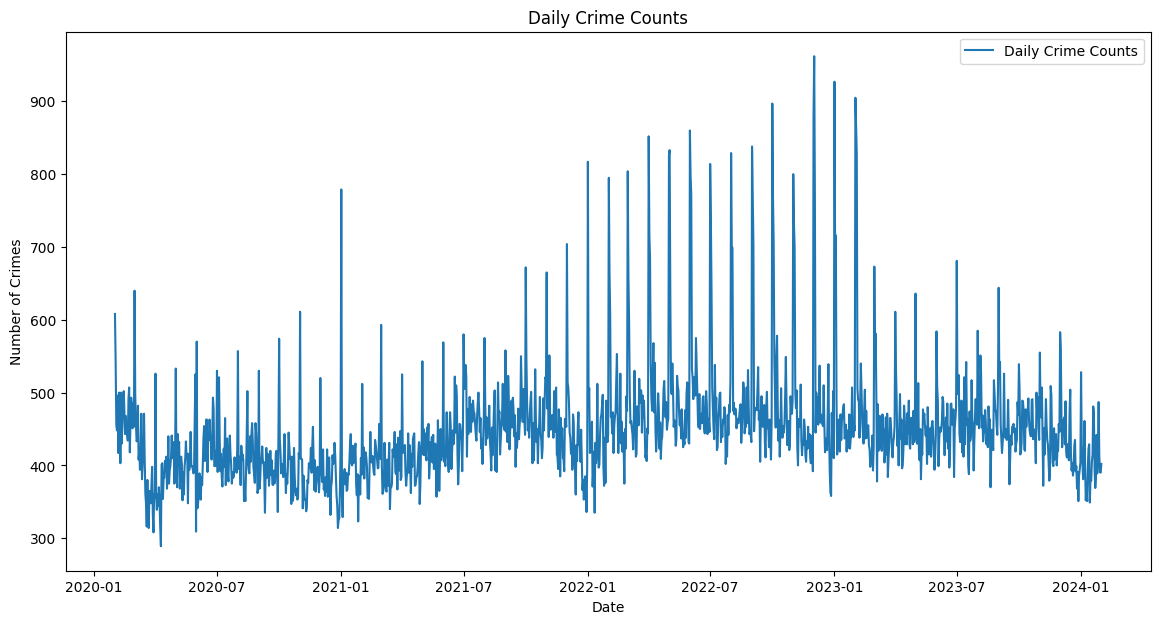

In [11]:
# Plot for daily crime counts
plt.figure(figsize=(14, 7))
plt.plot(crime_counts_per_day['Date'], crime_counts_per_day['CrimeCount'], label='Daily Crime Counts')
plt.title('Daily Crime Counts')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

In [12]:
# IQR Method
Q1 = crime_counts_per_day['CrimeCount'].quantile(0.25)
Q3 = crime_counts_per_day['CrimeCount'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = crime_counts_per_day[(crime_counts_per_day['CrimeCount'] < (Q1 - 1.5 * IQR)) | (crime_counts_per_day['CrimeCount'] > (Q3 + 1.5 * IQR))]
print("Outliers identified by IQR method:")
print(outliers_iqr)

Outliers identified by IQR method:
            Date  CrimeCount
0     2020-02-01         608
29    2020-03-01         640
68    2020-04-09         289
243   2020-10-01         574
274   2020-11-01         611
...          ...         ...
1216  2023-06-01         584
1246  2023-07-01         681
1277  2023-08-01         585
1308  2023-09-01         644
1399  2023-12-01         583

[63 rows x 2 columns]


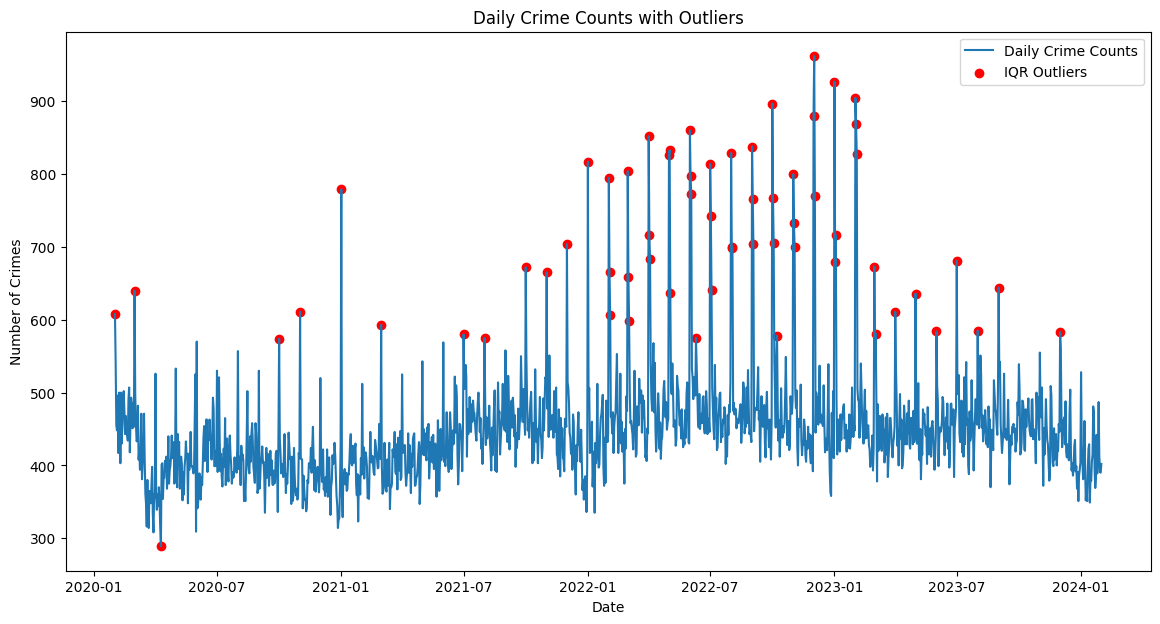

In [13]:
# Visualizing the outliers
plt.figure(figsize=(14, 7))
plt.plot(crime_counts_per_day['Date'], crime_counts_per_day['CrimeCount'], label='Daily Crime Counts')
plt.scatter(outliers_iqr['Date'], outliers_iqr['CrimeCount'], color='red', label='IQR Outliers')
plt.title('Daily Crime Counts with Outliers')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

In [14]:
# Removing the outliers and creating a cleaned dataset
df_cleaned = df[~df['DATE OCC'].dt.date.isin(pd.concat([outliers_iqr]).drop_duplicates()['Date'])]

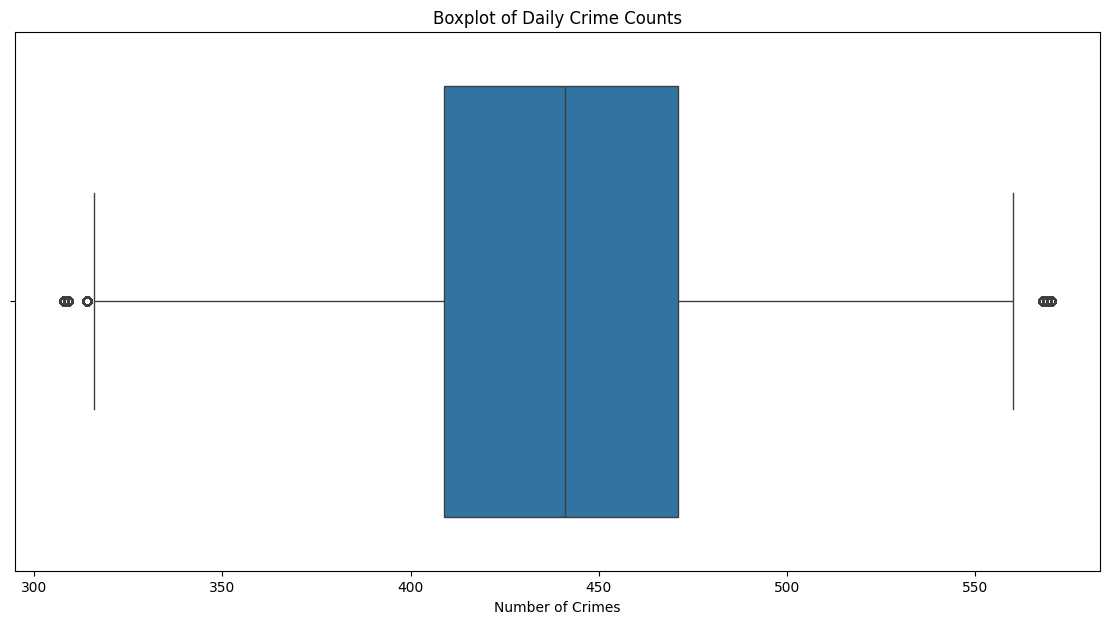

In [15]:
#boxplot for CrimeCount
plt.figure(figsize=(14, 7))
sns.boxplot(x=df_cleaned['CrimeCount'])
plt.title('Boxplot of Daily Crime Counts')
plt.xlabel('Number of Crimes')
plt.show()

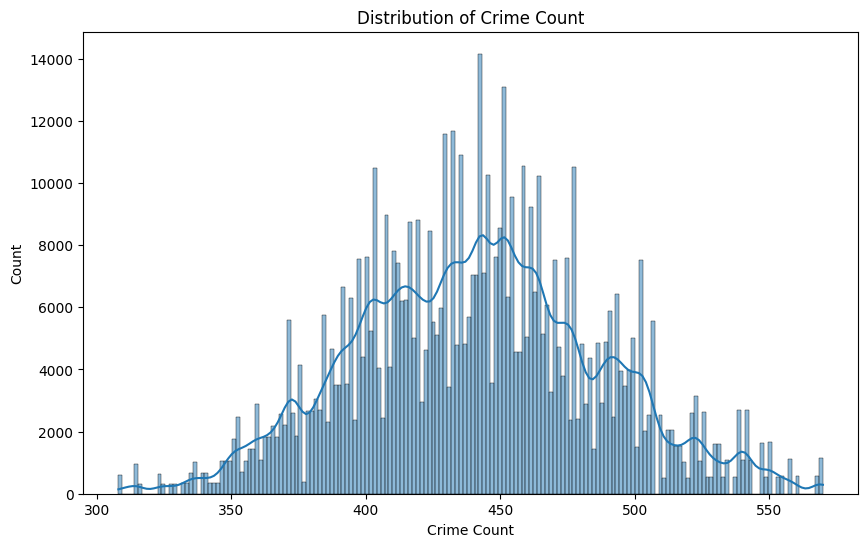

In [16]:
# Distribution of Crime count

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['CrimeCount'], kde=True)
plt.title('Distribution of Crime Count')
plt.xlabel('Crime Count')
plt.ylabel('Count')
plt.show()

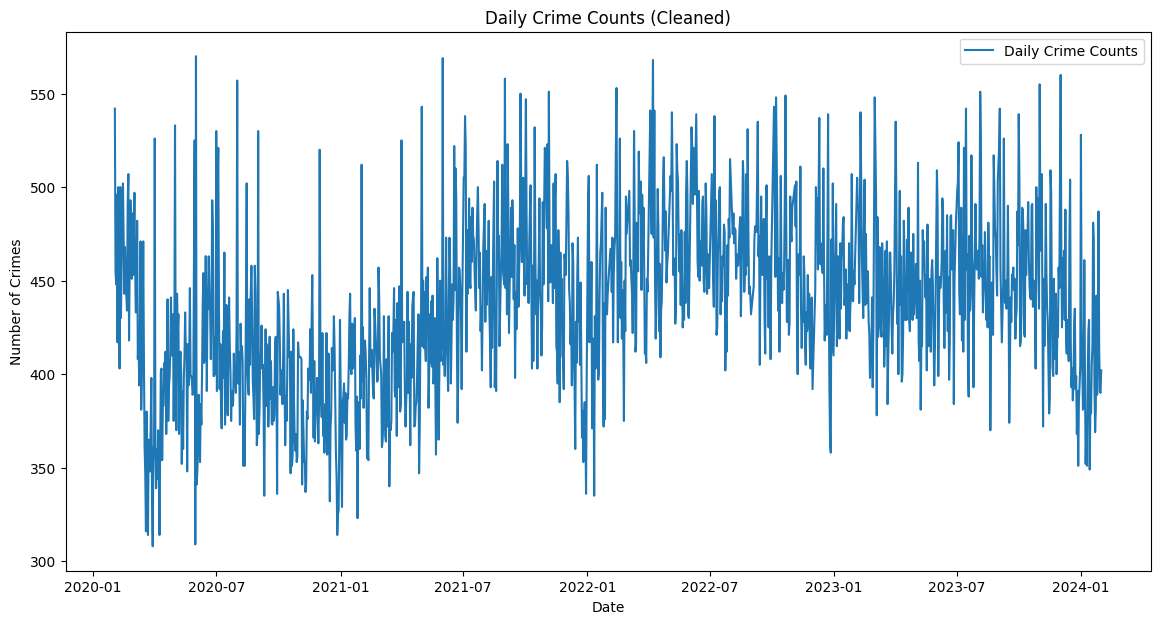

In [17]:
# Group the cleaned data by date and count incidents
daily_counts_cleaned = df_cleaned.groupby(df_cleaned['DATE OCC'].dt.date)['Crm Cd'].count().reset_index()
daily_counts_cleaned.columns = ['Date', 'CrimeCount']

# Plot for daily crime counts cleaned version
plt.figure(figsize=(14, 7))
plt.plot(daily_counts_cleaned['Date'], daily_counts_cleaned['CrimeCount'], label='Daily Crime Counts')
plt.title('Daily Crime Counts (Cleaned)')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()


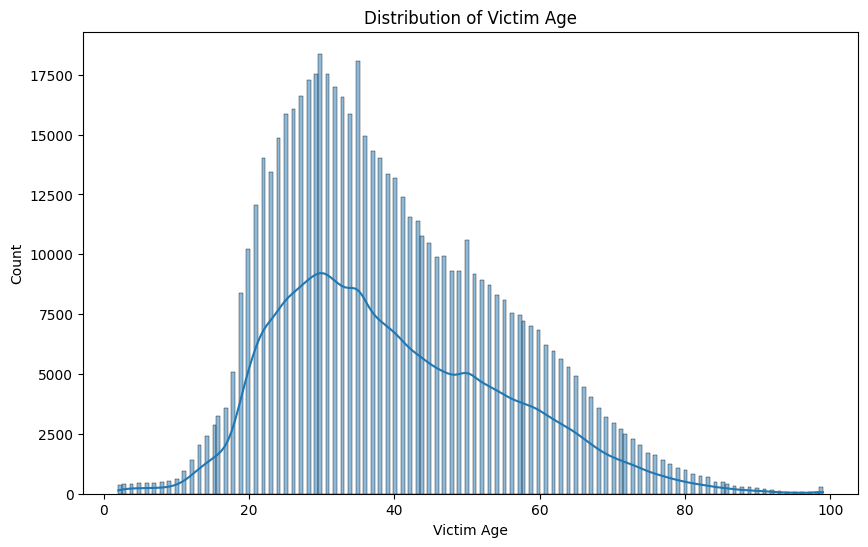

In [18]:
# Distribution of Victim Age
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['Vict Age'], kde=True)
plt.title('Distribution of Victim Age')
plt.xlabel('Victim Age')
plt.ylabel('Count')
plt.show()

/var/folders/rj/8qn9133n3txbjdm453y5f6w80000gn/T/ipykernel_38726/3918299449.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crime_types.values, y=crime_types.index, palette='viridis')


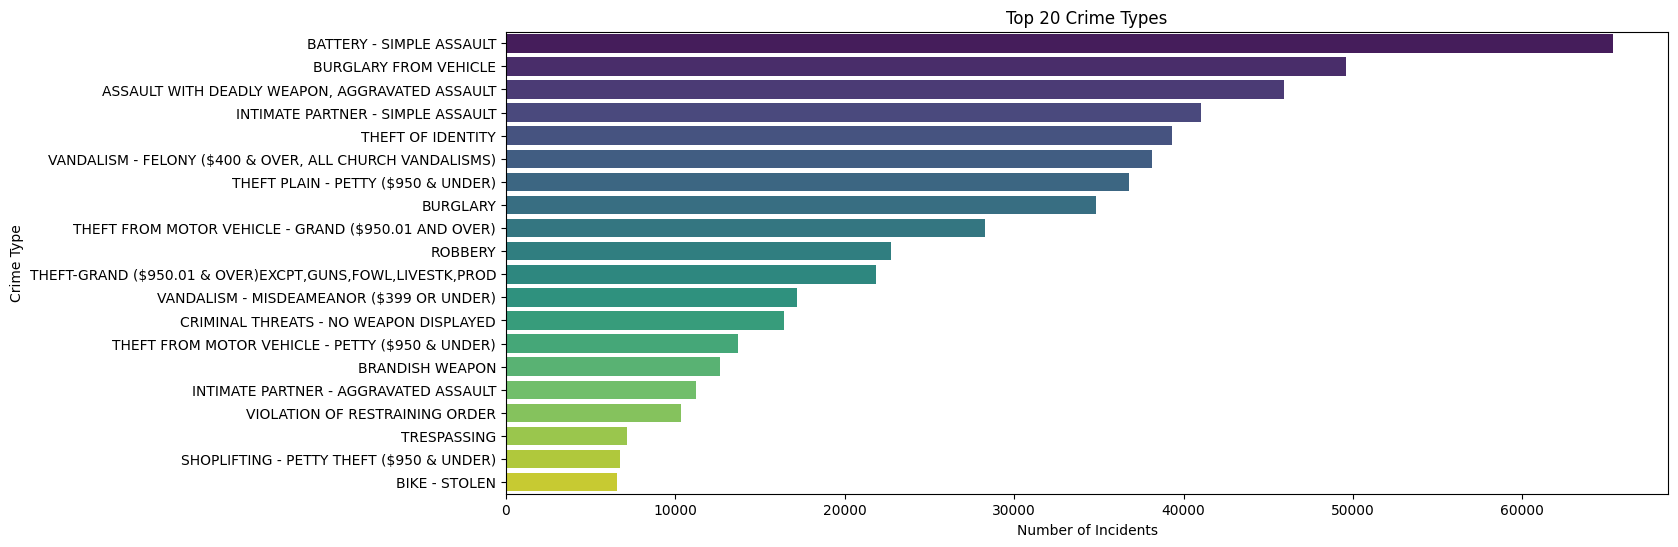

In [19]:
# Distribution of Crime Types
plt.figure(figsize=(15, 6))
crime_types = df_cleaned['Crm Cd Desc'].value_counts().head(20)  # Adjust this to view more or fewer crime types
sns.barplot(x=crime_types.values, y=crime_types.index, palette='viridis')
plt.title('Top 20 Crime Types')
plt.xlabel('Number of Incidents')
plt.ylabel('Crime Type')
plt.show()

/var/folders/rj/8qn9133n3txbjdm453y5f6w80000gn/T/ipykernel_38726/1430577993.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_cleaned, x='DayOfWeek', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='Spectral')


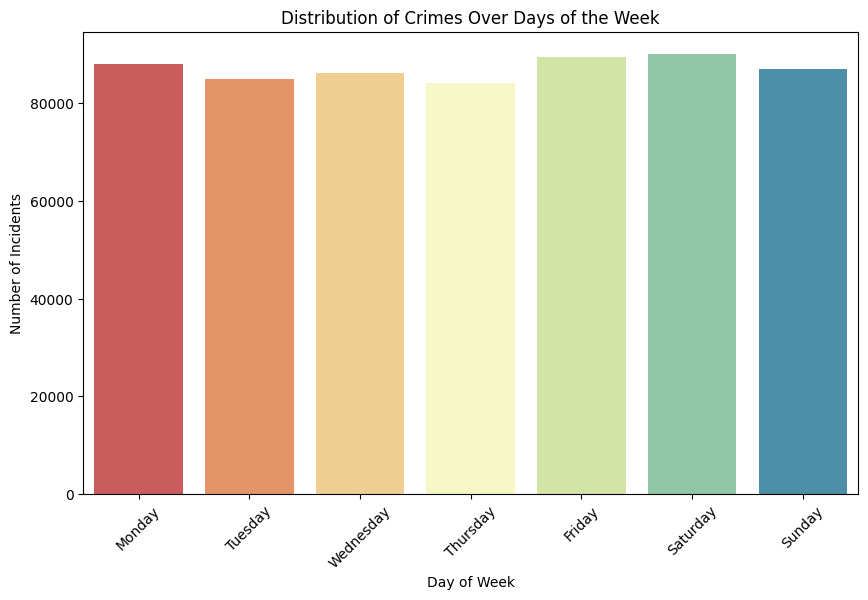

In [20]:
# Distribution of crime on weekdays
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='DayOfWeek', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='Spectral')
plt.title('Distribution of Crimes Over Days of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.show()

In [21]:
# Grouping the data by year and month to get the number of incidents per month
monthly_crimes = df_cleaned.groupby(['Year', 'Month']).size().reset_index(name='Incidents')

# Create a new feature YearMonth to use as the x-axis
monthly_crimes['YearMonth'] = monthly_crimes['Year'].astype(str) + '-' + monthly_crimes['Month'].astype(str).str.zfill(2)

# Plotting
fig = px.line(monthly_crimes, x='YearMonth', y='Incidents', title='Monthly Crime Trends',
              labels={'YearMonth': 'Date', 'Incidents': 'Number of Crimes'}, markers=True)
fig.update_xaxes(tickangle=45)
fig.show()

In [22]:
# Creating a new DataFrame to split the data into Area Name and Crime Code Description
df['AREA NAME'] = df_cleaned['AREA NAME'].astype('category')

# Find the top 5 crime types
top_crime_types = df_cleaned['Crm Cd Desc'].value_counts().head(5).index

# Filter the DataFrame to only include these top crime types
top_crimes_df = df_cleaned[df_cleaned['Crm Cd Desc'].isin(top_crime_types)]

# We can now group the data by Area Name and Crime Code Description to get the counts
area_crime_counts = df_cleaned[df_cleaned['Crm Cd Desc'].isin(top_crime_types)].groupby(['AREA NAME', 'Crm Cd Desc'], observed=True).size().reset_index(name='Counts')


# Plotting the data
fig = px.bar(area_crime_counts, x='Crm Cd Desc', y='Counts', color='AREA NAME', title='Comparison of Top 5 Crime Types Across Different Areas')

# Additional styling to improve readability
fig.update_layout(
    xaxis_title="Crime Type",
    yaxis_title="Number of Incidents",
    legend_title="Area Name",
    barmode='group'
)

fig.show()


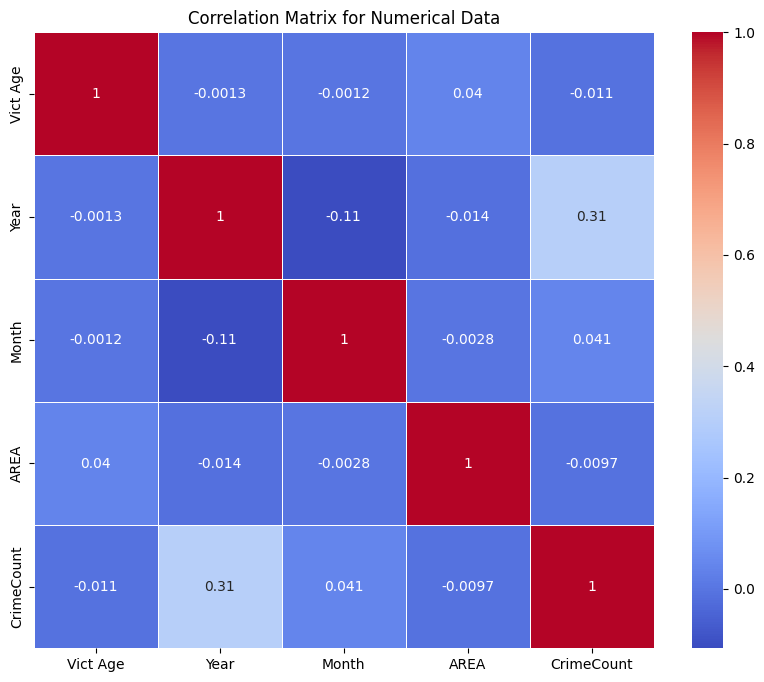

In [23]:
# Correlation Matrix for numerical columns
numerical_cols = ['Vict Age', 'Year', 'Month', 'AREA', "CrimeCount"]
correlation_matrix = df_cleaned[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix for Numerical Data')
plt.show()

In [24]:
# Heatmap of crime incidents
df_cleaned = df_cleaned[(df_cleaned['LAT'] >= 33.5) & (df_cleaned['LAT'] <= 34.5) & (df_cleaned['LON'] >= -118.75) & (df_cleaned['LON'] <= -117.75)]
m = folium.Map(location=[34.0522, -118.2437], zoom_start=10)
HeatMap([[row['LAT'], row['LON']] for index, row in df_cleaned.iterrows()]).add_to(m)
m.save('la_crime_heatmap.html')
webbrowser.open('file://' + os.path.realpath('la_crime_heatmap.html'))


True

In [25]:

# 10 clusters for the KMeans model for crime hotspots in LA 
n_clusters = 10

# Extracting latitude and longitude data for clustering
coords = df_cleaned[['LAT', 'LON']].values

# Create and fit the model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(coords)

labels = kmeans.labels_

# Counting the number of crimes in each cluster
crime_counts = pd.Series(labels).value_counts().sort_index()

# Getting the coordinates of the cluster centers (hotspots)
hotspots = kmeans.cluster_centers_

# Creating a map centered around LA
la_map = folium.Map(location=[34.0522, -118.2437], zoom_start=10)

# Adding hotspots to the map with markers and with the number of crimes in each hotspot
for i, coord in enumerate(hotspots):
    folium.Marker(
        location=[coord[0], coord[1]],
        popup=f'Hotspot {i+1}: {crime_counts[i]} crimes',
        icon=folium.Icon(color='red', icon='fire')
    ).add_to(la_map)

# Saving the map to an HTML file
la_map.save('la_crime_hotspots.html')
# Open the map in the default web browser
webbrowser.open('file://' + os.path.realpath('la_crime_hotspots.html'))


True

In [26]:
hotspots_data = pd.read_csv('data/hotspots_data.csv')

In [27]:
# Display the loaded data
print(hotspots_data.head())

         LAT        LONG    ZIP         Neighbourhood Population  \
0  34.067690 -118.329207  90020             Koreatown     38,124   
1  34.264998 -118.453371  91345         Mission Hills     18,752   
2  33.974845 -118.283218  90044     South Los Angeles    100,225   
3  34.058666 -118.246850  90012  Downtown Los Angeles     39,709   
4  34.187967 -118.373981  91606       North Hollywood     43,381   

  Number of Households Median Income$ Average Income$  Crime Count  
0               16,881      51,013.00       82,166.00       117774  
1                5,448      85,659.00       96,866.00        36699  
2               28,202      43,388.00       59,026.00        99495  
3               14,361      53,278.00       85,008.00       126884  
4               15,255      57,146.00       76,519.00        40883  


In [28]:
# Remove commas and convert columns to numeric
hotspots_data['Population'] = hotspots_data['Population'].str.replace(',', '').astype(int)
hotspots_data['Number of Households'] = hotspots_data['Number of Households'].str.replace(',', '').astype(int)
hotspots_data['Median Income$'] = hotspots_data['Median Income$'].str.replace(',', '').astype(float)
hotspots_data['Average Income$'] = hotspots_data['Average Income$'].str.replace(',', '').astype(float)

In [29]:
# Correlation matrix
corr_matrix = hotspots_data[['Population', 'Number of Households', 'Median Income$', 'Average Income$', 'Crime Count']].corr()

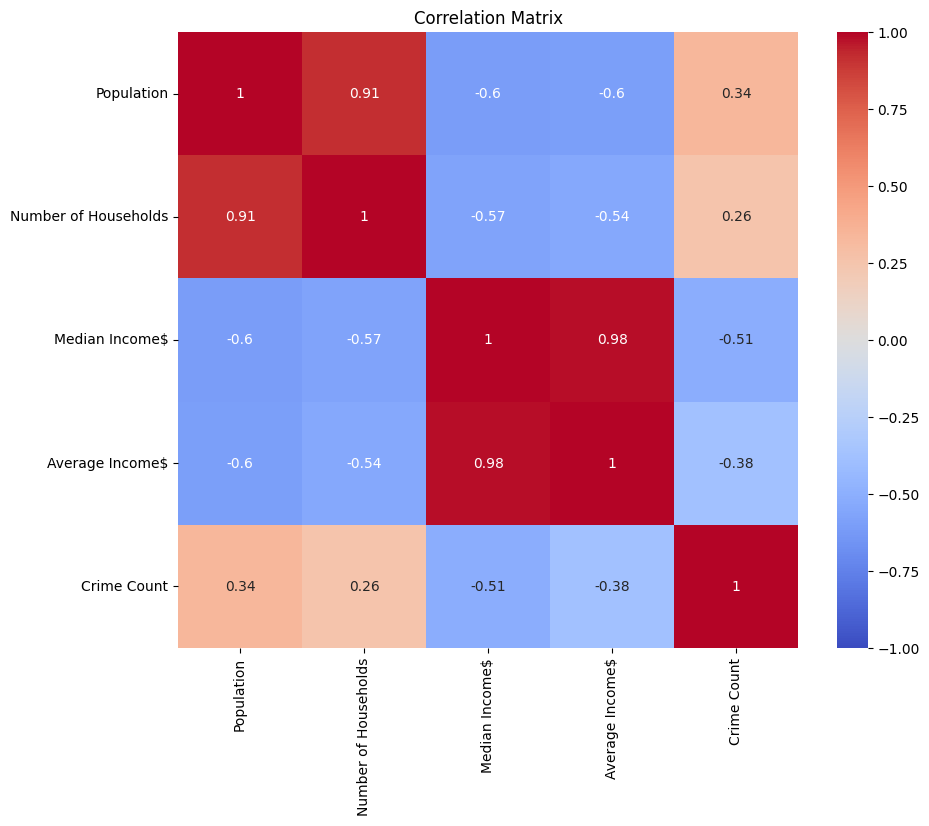

In [30]:
# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

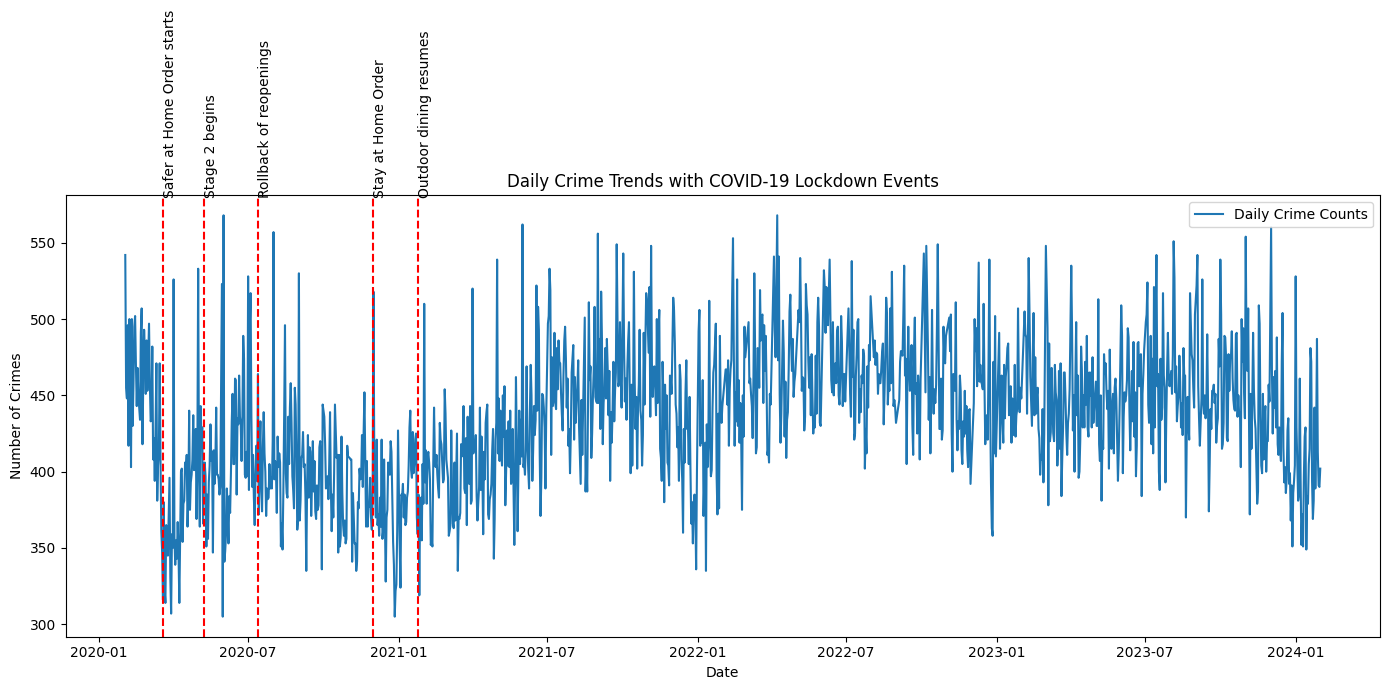

In [31]:
# Grouping data by date and count incidents
daily_counts = df_cleaned.groupby('DATE OCC').size()

# Creating a timeline with COVID-19 lockdown events
lockdown_events = {
    '2020-03-19': 'Safer at Home Order starts',
    '2020-05-08': 'Stage 2 begins',
    '2020-07-13': 'Rollback of reopenings',
    '2020-11-30': 'Stay at Home Order',
    '2021-01-25': 'Outdoor dining resumes',
   
}

# Plot daily crime trends
plt.figure(figsize=(14, 7))
plt.plot(daily_counts.index, daily_counts.values, label='Daily Crime Counts')

# Plot each lockdown event
for date, event in lockdown_events.items():
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--')
    plt.text(pd.to_datetime(date), plt.ylim()[1], event, rotation=90)

# Add labels and title
plt.title('Daily Crime Trends with COVID-19 Lockdown Events')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
violent_crimes = [
    'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
    'BATTERY - SIMPLE ASSAULT',
    'BATTERY WITH SEXUAL CONTACT',
    'BATTERY POLICE (SIMPLE)',
    'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT',
    'CRIMINAL HOMICIDE',
    'MANSLAUGHTER, NEGLIGENT',
    'CRIMINAL THREATS - NO WEAPON DISPLAYED',
    'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT',
    'INTIMATE PARTNER - SIMPLE ASSAULT',
    'INTIMATE PARTNER - AGGRAVATED ASSAULT',
    'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER',
    'OTHER ASSAULT',
    'CHILD ANNOYING (17YRS & UNDER)',
    'KIDNAPPING',
    'KIDNAPPING - GRAND ATTEMPT',
    'SHOTS FIRED AT INHABITED DWELLING',
    'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT',
    'DISCHARGE FIREARMS/SHOTS FIRED',
    'ARSON',
    'ATTEMPTED ROBBERY',
    'BRANDISH WEAPON',
    'CRUELTY TO ANIMALS',
    'FALSE IMPRISONMENT',
    'LYNCHING',
    'LYNCHING - ATTEMPTED',
    'PIMPING',
    'RAPE, FORCIBLE',
    'RAPE, ATTEMPTED',
    'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH',
    'SEXUAL PENETRATION W/FOREIGN OBJECT',
    'BATTERY ON A FIREFIGHTER',
    'THROWING OBJECT AT MOVING VEHICLE',
    'TRAIN WRECKING',
    'VIOLATION OF RESTRAINING ORDER',
    'VIOLATION OF TEMPORARY RESTRAINING ORDER',
    'CHILD NEGLECT (SEE 300 W.I.C.)',
    'CHILD ABANDONMENT',
    'CHILD STEALING',
    'CHILD PORNOGRAPHY',
    'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)',
    'LEWD/LASCIVIOUS ACTS WITH CHILD',
    'SEX OFFENDER REGISTRANT OUT OF COMPLIANCE',
    'LEWD CONDUCT',
    'PEEPING TOM',
    'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH',
    'ORAL COPULATION',
    'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ)',
    'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)',
    'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD',
    'BIGAMY',
    'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM',
    'EXTORTION',
    'RECKLESS DRIVING',
    'DRIVING WITHOUT OWNER CONSENT (DWOC)',
    'STALKING',
    'CONTEMPT OF COURT',
    'VIOLATION OF COURT ORDER',
    'THREATENING PHONE CALLS/LETTERS',
]


In [33]:
property_crimes = [
    'VEHICLE - STOLEN',
    'BURGLARY FROM VEHICLE',
    'BIKE - STOLEN',
    'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)',
    'THEFT OF IDENTITY',
    'CRIMINAL THREATS - NO WEAPON DISPLAYED',
    'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)',
    'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
    'BURGLARY',
    'THEFT PLAIN - PETTY ($950 & UNDER)',
    'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)',
    'OTHER MISCELLANEOUS CRIME',
    'ROBBERY',
    'BUNCO, GRAND THEFT',
    'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
    'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
    'BRANDISH WEAPON',
    'DOCUMENT FORGERY / STOLEN FELONY',
    'VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
    'CREDIT CARDS, FRAUD USE ($950.01 & OVER)',
    'EXTORTION',
    'PICKPOCKET',
    'ARSON',
    'TILL TAP - GRAND THEFT ($950.01 & OVER)',
    'VEHICLE - ATTEMPT STOLEN',
    'THEFT, PERSON',
    'THEFT FROM PERSON - ATTEMPT',
    'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER',
    'BUNCO, PETTY THEFT',
    'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $950 & UNDER',
    'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $950.01',
    'DISHONEST EMPLOYEE - GRAND THEFT',
    'DISHONEST EMPLOYEE - PETTY THEFT',
    'DOCUMENT WORTHLESS ($200.01 & OVER)',
    'DOCUMENT WORTHLESS ($200 & UNDER)',
    'DRUNK ROLL',
    'TILL TAP - PETTY ($950 & UNDER)',
    'ILLEGAL DUMPING',
    'GRAND THEFT / AUTO REPAIR',
    'GRAND THEFT / INSURANCE FRAUD',
    'THEFT, COIN MACHINE - GRAND ($950.01 & OVER)',
    'THEFT, COIN MACHINE - PETTY ($950 & UNDER)',
    'THEFT, COIN MACHINE - ATTEMPT',
    'BOAT - STOLEN',
    'COUNTERFEIT',
    'PURSE SNATCHING',
    'PURSE SNATCHING - ATTEMPT',
    'BIKE - ATTEMPTED STOLEN',

]

In [34]:
sex_crimes = [
    'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH',
    'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)',
    'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ)',
    'LEWD CONDUCT',
    'ORAL COPULATION',
    'RAPE, FORCIBLE',
    'SEXUAL PENETRATION W/FOREIGN OBJECT',
    'LEWD/LASCIVIOUS ACTS WITH CHILD',
    'INDECENT EXPOSURE',
    'PEEPING TOM',
    'PANDERING',
    'CHILD PORNOGRAPHY',
    'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM',
    'RAPE, ATTEMPTED'
   
]

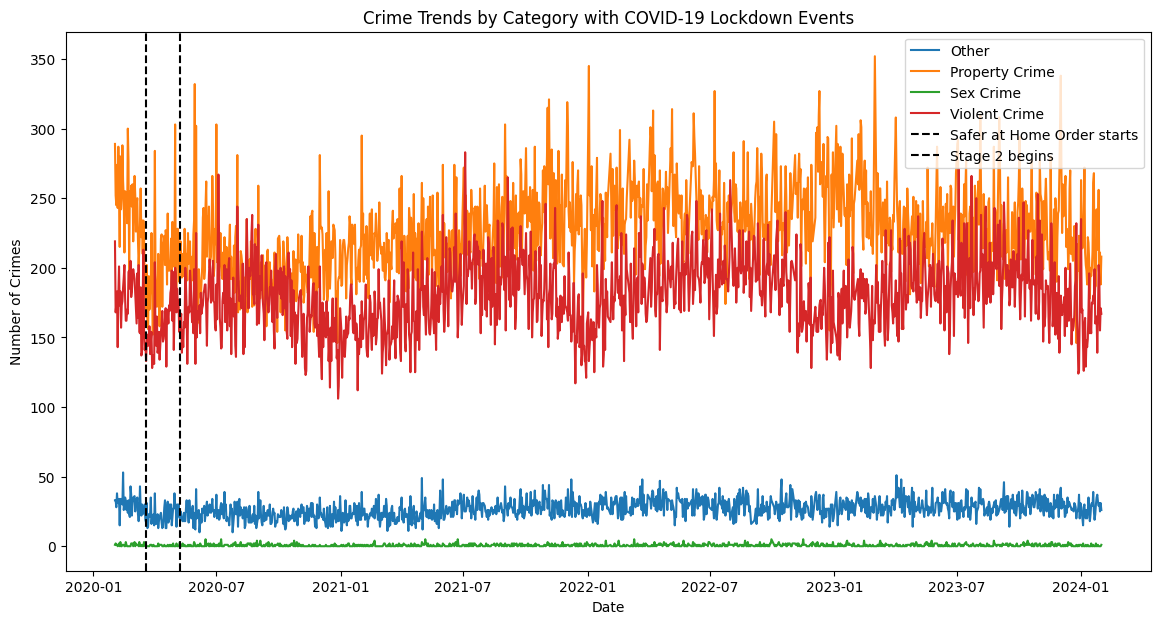

In [35]:
# Function to categorize crime
def categorize_crime(row):
    if row['Crm Cd Desc'] in violent_crimes:
        return 'Violent Crime'
    elif row['Crm Cd Desc'] in property_crimes:
        return 'Property Crime'
    elif row['Crm Cd Desc'] in sex_crimes:
        return 'Sex Crime'
    else:
        return 'Other'

# Applying categorization to the cleaned DataFrame
df_cleaned['Crime Category'] = df_cleaned.apply(categorize_crime, axis=1)

# Grouping data by date and category
daily_trends = df_cleaned.groupby([df_cleaned['DATE OCC'].dt.date, 'Crime Category']).size().unstack(fill_value=0)

# Plotting the trends
plt.figure(figsize=(14, 7))

for category in daily_trends.columns:
    plt.plot(daily_trends.index, daily_trends[category], label=category)

# Highlighting important dates with vertical lines
important_dates = {
    'Safer at Home Order starts': '2020-03-19',
    'Stage 2 begins': '2020-05-08',
}
for event, date in important_dates.items():
    plt.axvline(pd.to_datetime(date), color='k', linestyle='--', label=event)

plt.legend()
plt.title('Crime Trends by Category with COVID-19 Lockdown Events')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.show()


#Trying different ML Models and approaches


Mean Absolute Error: 27.285714285714285


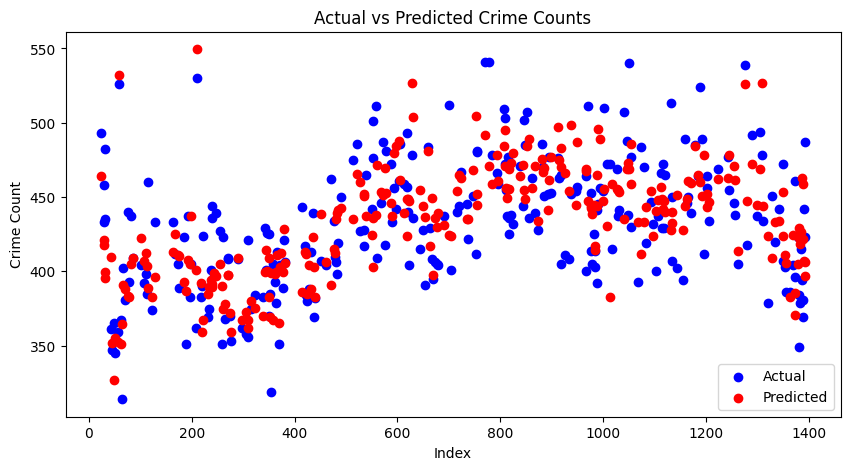

R^2 Score: 0.3425835802390139


['crime_model.pkl']

In [36]:
# Creating a DataFrame with the count of crimes per day
crime_counts_per_day = df_cleaned.groupby(df_cleaned['DATE OCC'].dt.date)['Crm Cd'].count().reset_index()
crime_counts_per_day.columns = ['Date', 'CrimeCount']

# Creating features (for this example, we'll only use the year, month, and day)
crime_counts_per_day['Year'] = pd.DatetimeIndex(crime_counts_per_day['Date']).year
crime_counts_per_day['Month'] = pd.DatetimeIndex(crime_counts_per_day['Date']).month
crime_counts_per_day['Day'] = pd.DatetimeIndex(crime_counts_per_day['Date']).day

# Preparing the data for the model
X = crime_counts_per_day[['Year', 'Month', 'Day']]  # Features
y = crime_counts_per_day['CrimeCount']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model on the training data
model.fit(X_train, y_train)

# Predicting
y_pred = model.predict(X_test)

# Evaluating
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Visualizing
plt.figure(figsize=(10, 5))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred, color='red', label='Predicted')
plt.title('Actual vs Predicted Crime Counts')
plt.xlabel('Index')
plt.ylabel('Crime Count')
plt.legend()
plt.show()

# R2 score
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

# Save the model to a file
joblib.dump(model, 'crime_model.pkl')

Training Mean Absolute Error: 0.0013486584526219481
Training R^2 Score: 0.9999989267466785
Test Mean Absolute Error: 0.0031200572170796254
Test R^2 Score: 0.9999948227009381
Cross-Validation Mean Absolute Error: 0.004454759384665969
Cross-Validation Scores: [0.00404119 0.00424609 0.00409863 0.00626299 0.0036249 ]


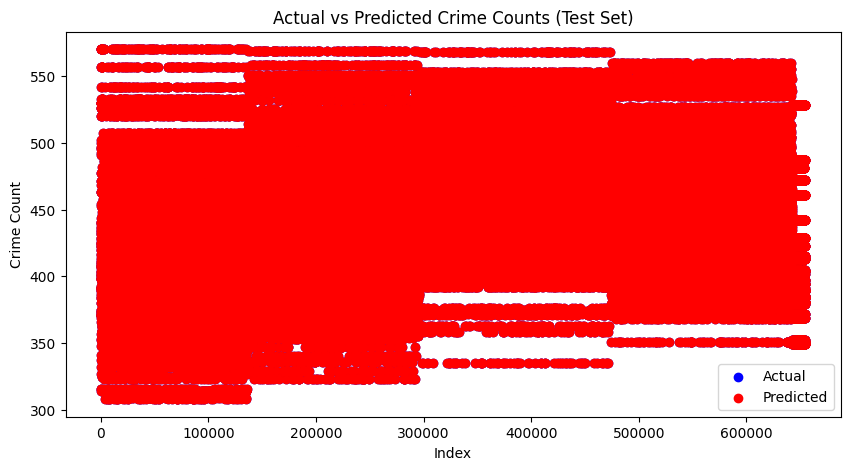

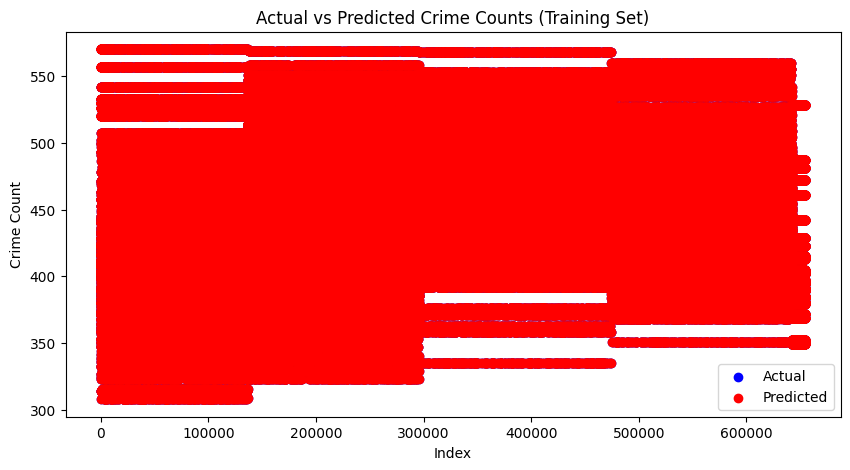

In [37]:
# Deriving additional features
df_cleaned['DayOfMonth'] = pd.DatetimeIndex(df_cleaned['DATE OCC']).day
df_cleaned['IsWeekend'] = df_cleaned['DayOfWeek'].apply(lambda x: 1 if x in [5, 6] else 0)

# Prepare the data for the model
features = df_cleaned[['Year', 'Month', 'DayOfWeek', 'AREA NAME', 'Part 1-2', 'Premis Desc', 'DayOfMonth', 'IsWeekend']]
target = df_cleaned['CrimeCount']  # Ensure this column is correctly aggregated if using daily crime counts

# Encode categorical features if not already encoded
features = pd.get_dummies(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Train the model on the full training set
model.fit(X_train, y_train)

# Predict on the training data
y_train_pred = model.predict(X_train)

# Predict on the testing data
y_test_pred = model.predict(X_test)

# Evaluate the model on the training data
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate the model on the testing data
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Output results
print(f'Training Mean Absolute Error: {mae_train}')
print(f'Training R^2 Score: {r2_train}')
print(f'Test Mean Absolute Error: {mae_test}')
print(f'Test R^2 Score: {r2_test}')
print(f'Cross-Validation Mean Absolute Error: {-np.mean(cv_scores)}')
print(f'Cross-Validation Scores: {-cv_scores}')

# Visualize the predictions vs the actual values for the test set
plt.figure(figsize=(10, 5))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_test_pred, color='red', label='Predicted')
plt.title('Actual vs Predicted Crime Counts (Test Set)')
plt.xlabel('Index')
plt.ylabel('Crime Count')
plt.legend()
plt.show()

# Visualize the predictions vs the actual values for the training set
plt.figure(figsize=(10, 5))
plt.scatter(X_train.index, y_train, color='blue', label='Actual')
plt.scatter(X_train.index, y_train_pred, color='red', label='Predicted')
plt.title('Actual vs Predicted Crime Counts (Training Set)')
plt.xlabel('Index')
plt.ylabel('Crime Count')
plt.legend()
plt.show()

GRADIENT BOOSTING REGRESSOR

Best Parameters (Gradient Boosting): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Gradient Boosting - Mean Absolute Error: 24.37551852417608
Gradient Boosting - R^2 Score: 0.4838705909312554


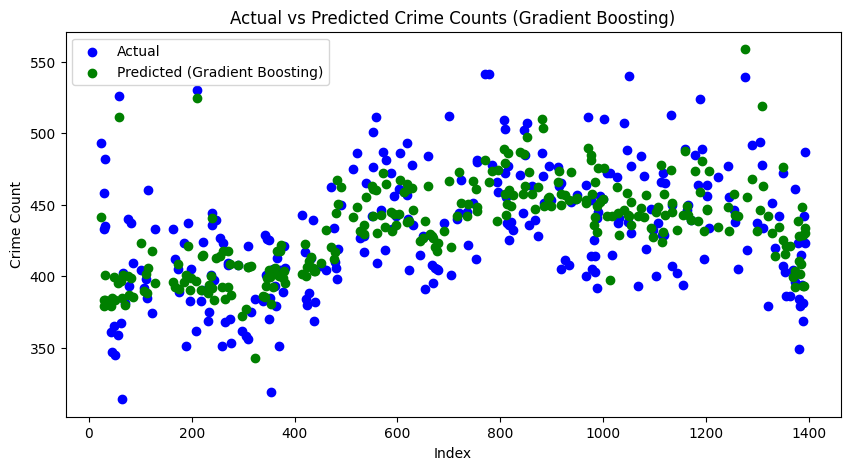

In [38]:

# Creating a DataFrame with the count of crimes per day
crime_counts_per_day = df_cleaned.groupby(df_cleaned['DATE OCC'].dt.date)['Crm Cd'].count().reset_index()
crime_counts_per_day.columns = ['Date', 'CrimeCount']

# Creating features (for this we'll use year, month, day, and dayofweek)
crime_counts_per_day['Year'] = pd.DatetimeIndex(crime_counts_per_day['Date']).year
crime_counts_per_day['Month'] = pd.DatetimeIndex(crime_counts_per_day['Date']).month
crime_counts_per_day['Day'] = pd.DatetimeIndex(crime_counts_per_day['Date']).day
crime_counts_per_day['DayOfWeek'] = pd.DatetimeIndex(crime_counts_per_day['Date']).dayofweek



# Preparing the data for the model
X = crime_counts_per_day[['Year', 'Month', 'Day', 'DayOfWeek']]  # Features
y = crime_counts_per_day['CrimeCount']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the model (Gradient Boosting)
gb_model = GradientBoostingRegressor(random_state=42)

# Hyperparameter tuning for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.5]
}

grid_search_gb = GridSearchCV(estimator=gb_model,
                           param_grid=param_grid_gb,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1)

grid_search_gb.fit(X_train, y_train)

best_params_gb = grid_search_gb.best_params_
print(f'Best Parameters (Gradient Boosting): {best_params_gb}')

best_model_gb = grid_search_gb.best_estimator_
y_pred_gb = best_model_gb.predict(X_test)

# Evaluating
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print(f'Gradient Boosting - Mean Absolute Error: {mae_gb}')
print(f'Gradient Boosting - R^2 Score: {r2_gb}')

# Visualizing
plt.figure(figsize=(10, 5))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_gb, color='green', label='Predicted (Gradient Boosting)')
plt.title('Actual vs Predicted Crime Counts (Gradient Boosting)')
plt.xlabel('Index')
plt.ylabel('Crime Count')
plt.legend()
plt.show()

##joblib.dump(best_model_gb, 'crime_model_gb.pkl')


LOADING THE OPTIMAL MODEL TO MAKE PREDICTIONS

In [39]:
# Load the saved model
model = joblib.load('crime_model_super.pkl')

# Prepare the data for March 2024
# Create a DataFrame with the same structure as the training data
dates = pd.date_range(start='2024-03-01', end='2024-03-31')
data = {
    'Year': [date.year for date in dates],
    'Month': [date.month for date in dates],
    'DayOfWeek': [date.weekday() for date in dates],  # Monday=0, Sunday=6
    'AREA NAME': ['Hollywood'] * len(dates),  
    'Part 1-2': ['2'] * len(dates),  
    'Premis Desc': ['102'] * len(dates),  
    'DayOfMonth': [date.day for date in dates],
    'IsWeekend': [1 if date.weekday() in [5, 6] else 0 for date in dates]
}

# Converting to DataFrame
df_new = pd.DataFrame(data)

# Encoding categorical features
df_new_encoded = pd.get_dummies(df_new)

# Aligning the new data's columns with the model's expected features
missing_cols = set(features.columns) - set(df_new_encoded.columns)
for col in missing_cols:
    df_new_encoded[col] = 0
df_new_encoded = df_new_encoded[features.columns]

# Make predictions
predictions = model.predict(df_new_encoded)

# Print or analyze the predictions
for date, prediction in zip(dates, predictions):
    print(f'Date: {date.strftime("%Y-%m-%d")}, Predicted Crime Count: {prediction}')


Date: 2024-03-01, Predicted Crime Count: 528.0
Date: 2024-03-02, Predicted Crime Count: 425.44
Date: 2024-03-03, Predicted Crime Count: 407.2
Date: 2024-03-04, Predicted Crime Count: 396.46
Date: 2024-03-05, Predicted Crime Count: 396.46
Date: 2024-03-06, Predicted Crime Count: 396.02
Date: 2024-03-07, Predicted Crime Count: 396.02
Date: 2024-03-08, Predicted Crime Count: 351.56
Date: 2024-03-09, Predicted Crime Count: 351.56
Date: 2024-03-10, Predicted Crime Count: 351.32
Date: 2024-03-11, Predicted Crime Count: 351.32
Date: 2024-03-12, Predicted Crime Count: 351.29
Date: 2024-03-13, Predicted Crime Count: 350.14
Date: 2024-03-14, Predicted Crime Count: 350.14
Date: 2024-03-15, Predicted Crime Count: 382.6
Date: 2024-03-16, Predicted Crime Count: 380.6
Date: 2024-03-17, Predicted Crime Count: 412.96
Date: 2024-03-18, Predicted Crime Count: 413.26
Date: 2024-03-19, Predicted Crime Count: 413.26
Date: 2024-03-20, Predicted Crime Count: 370.79
Date: 2024-03-21, Predicted Crime Count: 370

/var/folders/rj/8qn9133n3txbjdm453y5f6w80000gn/T/ipykernel_38726/1632857029.py:27: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/rj/8qn9133n3txbjdm453y5f6w80000gn/T/ipykernel_38726/1632857029.py:27: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/rj/8qn9133n3txbjdm453y5f6w80000gn/T/ipykernel_38726/1632857029.py:27: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

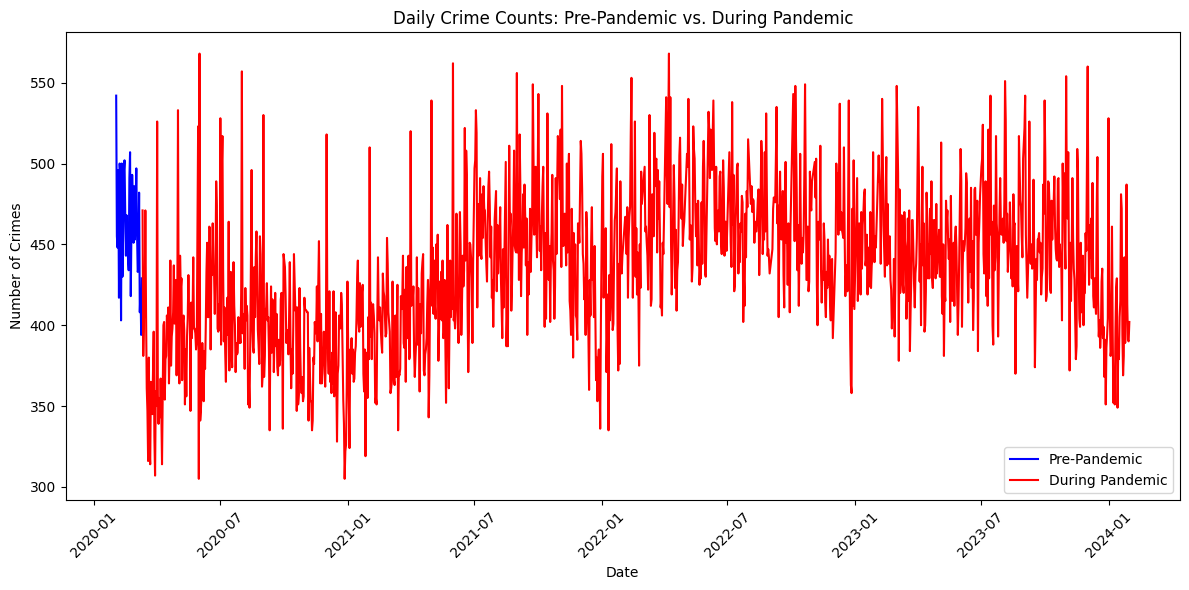

In [40]:

# Defining the start date of the pandemic as a cut-off point
pandemic_start = pd.to_datetime('2020-03-11')

df_cleaned['DATE OCC'] = pd.to_datetime(df_cleaned['DATE OCC'])

# Splitting the dataset into before and during the pandemic
df_pre_pandemic = df_cleaned[df_cleaned['DATE OCC'] < pandemic_start]
df_during_pandemic = df_cleaned[df_cleaned['DATE OCC'] >= pandemic_start]

# Visualizing the total crime counts before and during the pandemic
plt.figure(figsize=(12, 6))
plt.plot(df_pre_pandemic.groupby(df_pre_pandemic['DATE OCC'].dt.date).size(), label='Pre-Pandemic', color='blue')
plt.plot(df_during_pandemic.groupby(df_during_pandemic['DATE OCC'].dt.date).size(), label='During Pandemic', color='red')
plt.title('Daily Crime Counts: Pre-Pandemic vs. During Pandemic')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [41]:
# Hotspots before pandemic
coords_pre = df_pre_pandemic[['LAT', 'LON']].values
hotspots_pre = KMeans(n_clusters=10, random_state=42).fit(coords_pre).cluster_centers_

# Hotspots during pandemic
coords_during = df_during_pandemic[['LAT', 'LON']].values
hotspots_during = KMeans(n_clusters=10, random_state=42).fit(coords_during).cluster_centers_

# Function to plot hotspots
def plot_hotspots(hotspots, title):
    map_ = folium.Map(location=[34.0522, -118.2437], zoom_start=10)
    for i, coord in enumerate(hotspots):
        folium.Marker(
            location=[coord[0], coord[1]],
            popup=f'Hotspot {i+1}',
            icon=folium.Icon(color='red', icon='fire')
        ).add_to(map_)
    map_.save(f'{title}.html')
    webbrowser.open(f'file://' + os.path.realpath(f'{title}.html'))

plot_hotspots(hotspots_pre, 'pre_pandemic_hotspots')
plot_hotspots(hotspots_during, 'during_pandemic_hotspots')


In [42]:
# Calculating average daily crime counts for both periods
avg_daily_pre_pandemic = df_pre_pandemic.groupby(df_pre_pandemic['DATE OCC'].dt.date).size().mean()
avg_daily_during_pandemic = df_during_pandemic.groupby(df_during_pandemic['DATE OCC'].dt.date).size().mean()

def percentage_change(current, previous):
    if current == previous:
        return 0
    try:
        return (current - previous) / previous * 100.0
    except ZeroDivisionError:
        return float('inf')

# Calculating the percentage change in average daily crime counts
change = percentage_change(avg_daily_during_pandemic, avg_daily_pre_pandemic)
print(f"The average daily crime count changed by {change:.2f}% during the pandemic.")


The average daily crime count changed by -5.68% during the pandemic.


13:12:14 - cmdstanpy - INFO - Chain [1] start processing
13:12:14 - cmdstanpy - INFO - Chain [1] done processing
/Users/turan/Downloads/HideNSeek-main 2/venv/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/turan/Downloads/HideNSeek-main 2/venv/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



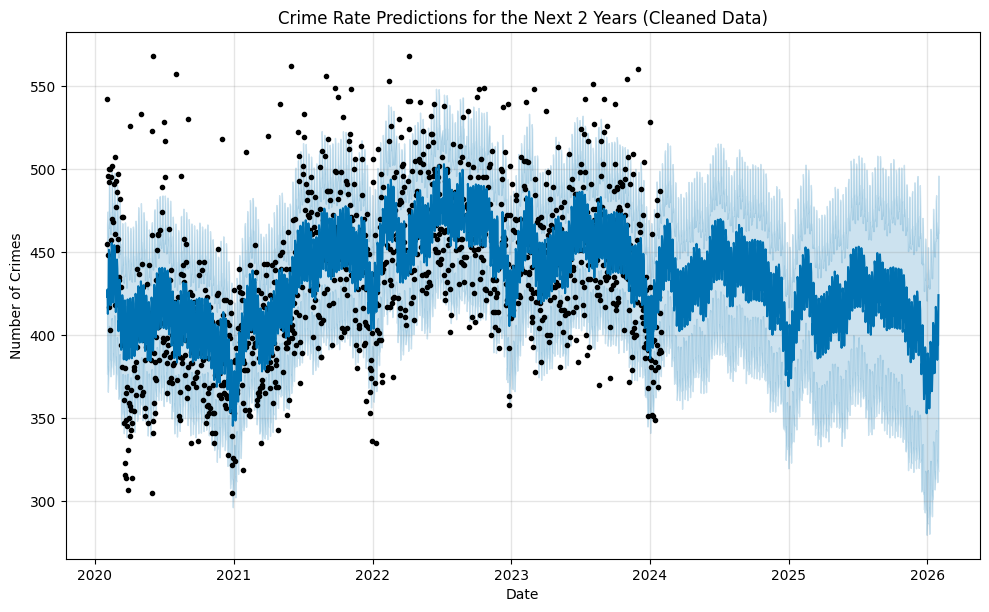

/Users/turan/Downloads/HideNSeek-main 2/venv/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/turan/Downloads/HideNSeek-main 2/venv/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/turan/Downloads/HideNSeek-main 2/venv/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

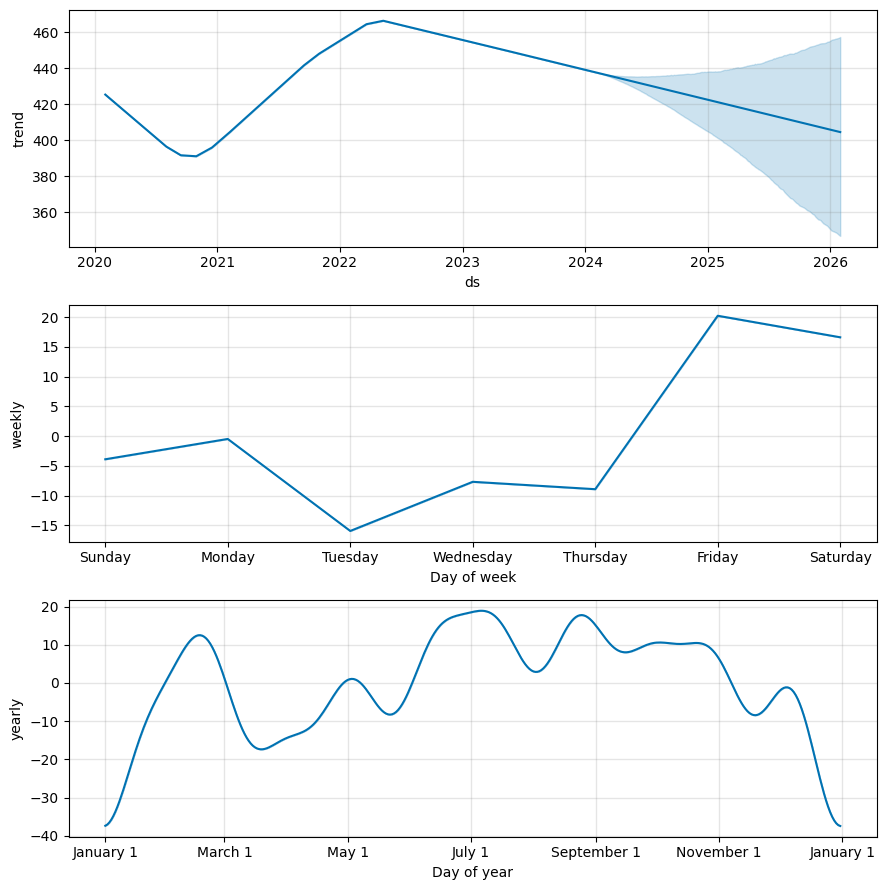

In [43]:
# Preparing the data for Prophet
cleaned_crime_counts_per_day_prophet = df_cleaned.groupby(df_cleaned['DATE OCC'].dt.date)['Crm Cd'].count().reset_index()
cleaned_crime_counts_per_day_prophet.columns = ['ds', 'y']

# Initializing the Prophet model
model = Prophet()

# Fitting the model on the cleaned data
model.fit(cleaned_crime_counts_per_day_prophet)

# Creatong a dataframe for future dates (next 2 years)
future = model.make_future_dataframe(periods=2*365)

# predicting
forecast = model.predict(future)

# Plot
fig = model.plot(forecast)
plt.title('Crime Rate Predictions for the Next 2 Years (Cleaned Data)')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.show()

# Plot the forecast components (trend, weekly, yearly seasonality)
fig2 = model.plot_components(forecast)
plt.show()

# Save the forecast to a CSV file
forecast.to_csv('cleaned_crime_rate_forecast.csv', index=False)
